In [1]:
!pip install librosa soundfile 


Preprocessing and Downsampling

In [3]:
import os
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

def pad_waveform(waveform, desired_length):
    if len(waveform) < desired_length:
        pad_width = desired_length - len(waveform)
        waveform = np.pad(waveform, (0, pad_width), mode='constant')
    else:
        waveform = waveform[:desired_length]
    return waveform

def downsample_audio(input_dir, output_dir, target_sr=2000, max_len_16k=269760):
    os.makedirs(output_dir, exist_ok=True)
    scaler = MinMaxScaler(feature_range=(-1, 1))

    for subdir, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.wav') and ("1240" in file or "1241" in file):  # ✅ Allow both 1240 and 1241
                file_path = os.path.join(subdir, file)

                waveform_16k, sr = librosa.load(file_path, sr=16000)
                waveform_16k = scaler.fit_transform(waveform_16k.reshape(-1, 1)).flatten()
                waveform_16k = pad_waveform(waveform_16k, max_len_16k)

                waveform_2k = librosa.resample(waveform_16k, orig_sr=16000, target_sr=target_sr)
                waveform_2k = pad_waveform(waveform_2k, max_len_16k // 8)

                output_path = os.path.join(output_dir, f"2k_{file}")
                sf.write(output_path, waveform_2k, target_sr)
    print("✅ Downsampling & padding completed.")

# Paths
original_directory = '/kaggle/input/16000hzwav/16000Hz/103'  # ✅ Folder containing 1240 and 1241
downsampled_directory = '/kaggle/working/2kHz_audio'

# Start Step 1
downsample_audio(original_directory, downsampled_directory)

# ------------------------------
# STEP 2: Prepare Data
# ------------------------------

def prepare_data(downsampled_dir, original_dir, target_sr=2000, original_sr=16000, input_len=33720, target_len=269760):
    input_data = []
    target_data = []
    total_duration_seconds = 0

    for subdir, dirs, files in os.walk(downsampled_dir):
        for file in files:
            if file.endswith('.wav') and file.startswith("2k_"):
                original_file = file.replace("2k_", "")
                if not ("1240" in original_file or "1241" in original_file):
                    continue

                # Load downsampled 2kHz
                waveform_2k, _ = librosa.load(os.path.join(subdir, file), sr=target_sr)
                waveform_2k = pad_waveform(waveform_2k, input_len)

                # Search for original file inside original_dir recursively
                original_path = None
                for root, _, filenames in os.walk(original_dir):
                    if original_file in filenames:
                        original_path = os.path.join(root, original_file)
                        break

                if original_path is None:
                    continue  # Original file not found

                waveform_16k, _ = librosa.load(original_path, sr=original_sr)
                waveform_16k = pad_waveform(waveform_16k, target_len)

                input_data.append(waveform_2k)
                target_data.append(waveform_16k)

                total_duration_seconds += (target_len / original_sr)

    input_data = np.array(input_data).reshape(-1, input_len, 1)
    target_data = np.array(target_data).reshape(-1, target_len, 1)

    total_minutes = total_duration_seconds / 60

    print(f"✅ Prepared {len(input_data)} samples.")
    print(f"🕒 Total duration: {total_minutes:.2f} minutes.")

    return input_data, target_data

input_len = 33720
target_len = 269760

# Start Step 2
input_data, target_data = prepare_data(downsampled_directory, original_directory, input_len=input_len, target_len=target_len)


2025-04-27 09:20:01.111036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745745601.362203      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745745601.441391      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Downsampling & padding completed.
✅ Prepared 102 samples.
🕒 Total duration: 28.66 minutes.


In [4]:
import numpy as np
from scipy.interpolate import interp1d
import soundfile as sf
import os

# Your existing low_sr_input (example)
i = 1
low_sr_input = input_data[i].reshape(1, input_len, 1)  # Shape (1, input_len, 1)
ground_truth = target_data[i].flatten()
# Squeeze to 1D
y = low_sr_input.squeeze()  # Shape (input_len,)

# Define sampling rates
original_sr = 2000   # Low sampling rate
target_sr = 16000    # Target upsampling rate

# Create time axes
duration = len(y) / original_sr
x_old = np.linspace(0, duration, len(y))
x_new = np.linspace(0, duration, int(duration * target_sr))

# Linear interpolation
f_linear = interp1d(x_old, y, kind='linear')
y_linear = f_linear(x_new)
sf.write("/kaggle/working/linear_interp.wav", y_linear, target_sr)
print(f"✅ Linear interpolation saved at: {os.path.abspath('linear_interp3.wav')}")

# Cubic interpolation
f_cubic = interp1d(x_old, y, kind='cubic')
y_cubic = f_cubic(x_new)
sf.write("/kaggle/working/cubic_interp.wav", y_cubic, target_sr)
print(f"✅ Cubic interpolation saved at: {os.path.abspath('cubic_interp3.wav')}")

# Nearest-Neighbor interpolation
f_nearest = interp1d(x_old, y, kind='nearest')
y_nearest = f_nearest(x_new)
sf.write("/kaggle/working/nearest_interp.wav", y_nearest, target_sr)
print(f"✅ Nearest-Neighbor interpolation saved at: {os.path.abspath('nearest_interp3.wav')}")

# Spline interpolation (Quadratic)
f_quadratic = interp1d(x_old, y, kind='quadratic')
y_quadratic = f_quadratic(x_new)
sf.write("/kaggle/working/spline_interp.wav", y_quadratic, target_sr)
print(f"✅ Spline interpolation saved at: {os.path.abspath('spline_interp3.wav')}")


✅ Linear interpolation saved at: /kaggle/working/linear_interp3.wav
✅ Cubic interpolation saved at: /kaggle/working/cubic_interp3.wav
✅ Nearest-Neighbor interpolation saved at: /kaggle/working/nearest_interp3.wav
✅ Spline interpolation saved at: /kaggle/working/spline_interp3.wav


✅ Ground truth saved to /kaggle/working/ground_truth.wav


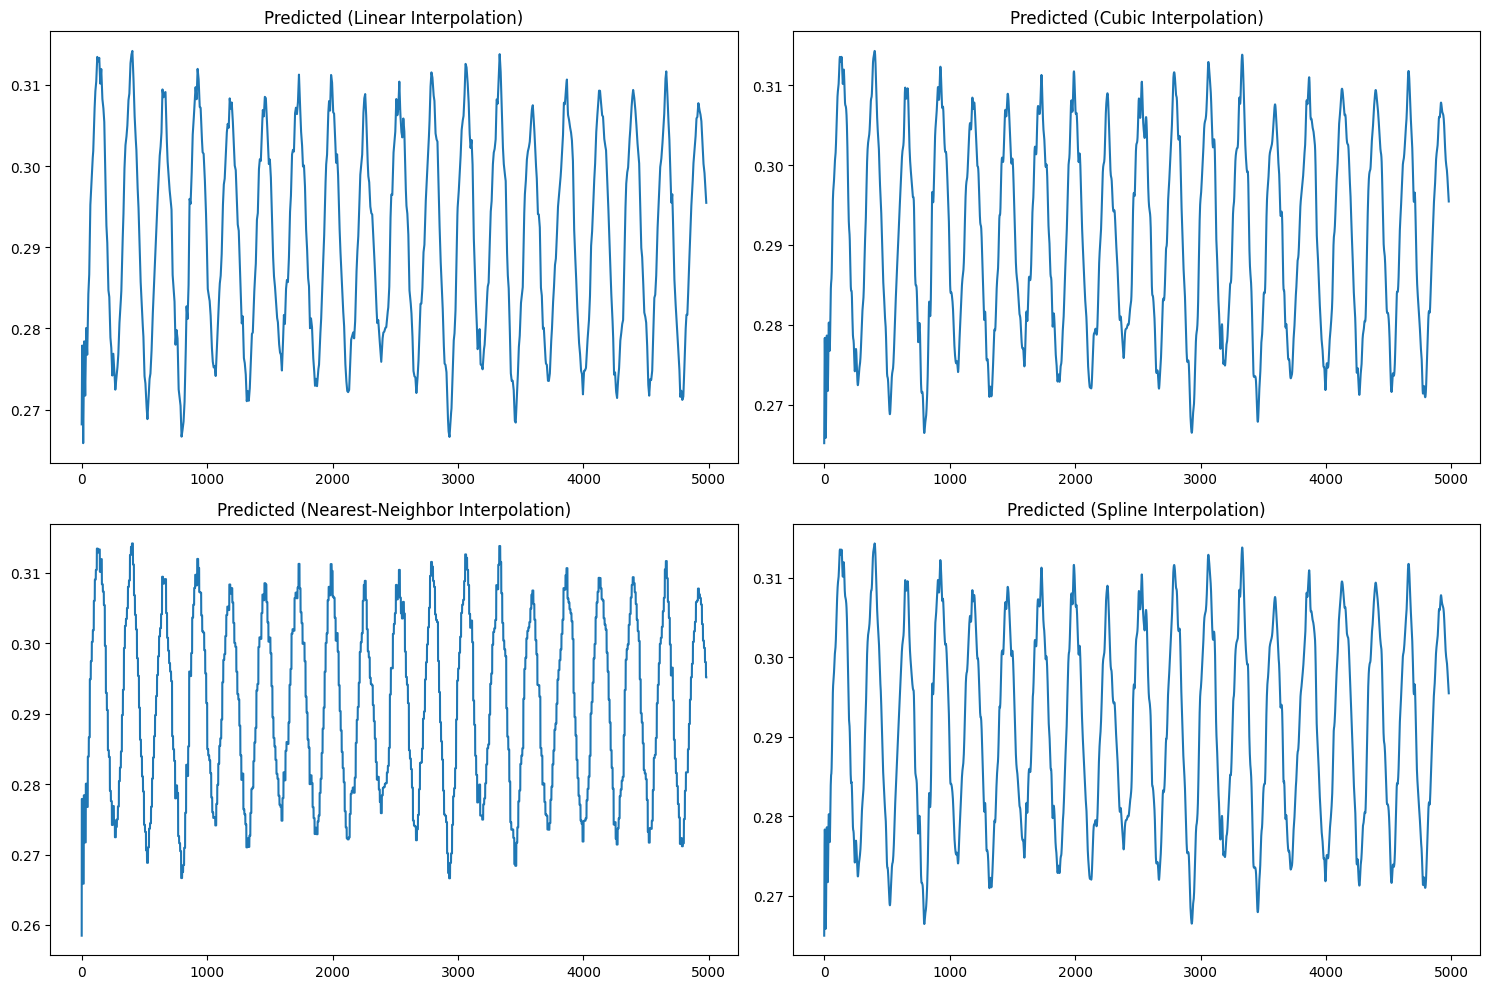

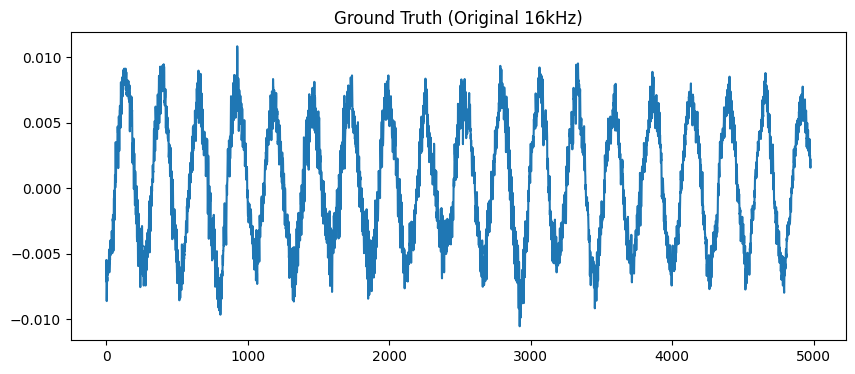

In [6]:
import numpy as np
from scipy.interpolate import interp1d
import soundfile as sf
import os
import matplotlib.pyplot as plt
# Save ground truth for comparison
gt_audio_path = "/kaggle/working/ground_truth.wav"
sf.write(gt_audio_path, ground_truth, 16000)
print(f"✅ Ground truth saved to {gt_audio_path}")

# Plotting the results
plt.figure(figsize=(15, 10))

# Linear Interpolation Plot
plt.subplot(2, 2, 1)
plt.plot(y_linear[20:5000])
plt.title("Predicted (Linear Interpolation)")

# Cubic Interpolation Plot
plt.subplot(2, 2, 2)
plt.plot(y_cubic[20:5000])
plt.title("Predicted (Cubic Interpolation)")

# Nearest-Neighbor Interpolation Plot
plt.subplot(2, 2, 3)
plt.plot(y_nearest[20:5000])
plt.title("Predicted (Nearest-Neighbor Interpolation)")

# Spline Interpolation Plot
plt.subplot(2, 2, 4)
plt.plot(y_quadratic[20:5000])
plt.title("Predicted (Spline Interpolation)")

plt.tight_layout()
plt.show()

# Also show the ground truth for comparison
plt.figure(figsize=(10, 4))
plt.plot(ground_truth[20:5000])
plt.title("Ground Truth (Original 16kHz)")
plt.show()